# Graphene with N randomly positioned adatoms

In [1]:
import kwant
import tinyarray
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

## Definition of the Graphene strip

Let's start by defining a system without SOC terms, but with two orbitals per site representing the spin. To do so, we've adopted the `general` lattice definition from `kwant.lattice` module. Such a function needs the primitive vectors and the coordinates of the basis atoms:

**Primitive vectors:**
* (1, 0)
* ($\sin 30°$, $\cos 30°$)

**Coordinates of basis atoms:**
* (0, 0)
* (0, $\frac{1}{\sqrt 3}$)

In [2]:
zeros_2x2 = tinyarray.array([[0,0],[0,0]])
sigma_0 = tinyarray.array([[1,0],[0,1]])
sigma_x = tinyarray.array([[0,1],[1,0]])
sigma_y = tinyarray.array([[0,-1j],[1j,0]])
sigma_z = tinyarray.array([[1,0],[0,-1]])

### Builder function:

In [3]:
class Rectangle:
    """
    Class to define callable objects to define the 
    shape of the scattering region of a rectangular
    system.
    """
    def __init__(self, W, L):
        '''
        Calling the scattering region as strip:
        W = width of the strip
        L = length of the strip 
        '''
        self.W = W
        self.L = L
        
    def __call__(self, pos):
        W, L = self.W, self.L
        x, y = pos
        return -W/2 < y < W/2 and -L/2 <= x <= L/2
    
    def leads(self, pos):
        W = self.W
        _, y = pos
        return -W/2 < y < W/2

def make_graphene_strip(lattice, scatter_shape, hopping=1, on_site=0):    
    syst = kwant.Builder()
    syst[lattice.shape(scatter_shape, (0, 0))] = on_site

    # specify the hoppings of the graphene lattice in the
    # format expected by builder.HoppingKind
    a, b = lattice.sublattices
    hoppings = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = hopping
    
    syst.eradicate_dangling()
    include_ISOC(syst, [a,b], lambda_I=1)
    return syst


def make_graphene_leads(lattice, lead_shape, hopping=1, on_site=0):
    a, b = lattice.sublattices
    symmetry = kwant.TranslationalSymmetry((-1,0))
    symmetry.add_site_family(a, other_vectors=[(-1,2)])
    symmetry.add_site_family(b, other_vectors=[(-1,2)])
    
    lead_0 = kwant.Builder(symmetry)
    lead_0[lattice.shape(lead_shape, (0,0))] = on_site
    
    hoppings = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
    lead_0[(kwant.builder.HoppingKind(*hopping) for hopping in hoppings)] = hopping
    lead_0.eradicate_dangling()
    
    include_ISOC(lead_0, [a,b], lambda_I=1)
    
    lead_1 = lead_0.reversed()
    return [lead_0, lead_1]


def include_ISOC(system, G_sub_lattices, lambda_I=1):
    """
    ## INCLUDING THE INTRINSIC SOC (isoc):
    system         := kwant.builder.Builder
    G_sub_lattices := list of Graphene sublattices
    lambda_I       := parameter  
    """
    sub_a, sub_b = G_sub_lattices
    # lambda_I   = 1 ## non-realistic; see reference: PRL 110, 246602 (2013)
    H_isoc = -1j/3 * lambda_I/np.sqrt(3) * sigma_z # counter-clockwise
    system[kwant.builder.HoppingKind((1,0), sub_a, sub_a)]  =  H_isoc
    system[kwant.builder.HoppingKind((0,1), sub_a, sub_a)]  = -H_isoc
    system[kwant.builder.HoppingKind((-1,1), sub_a, sub_a)] =  H_isoc
    system[kwant.builder.HoppingKind((1,0), sub_b, sub_b)]  =  H_isoc
    system[kwant.builder.HoppingKind((0,1), sub_b, sub_b)]  =  H_isoc
    system[kwant.builder.HoppingKind((-1,1), sub_b, sub_b)] = -H_isoc


In [4]:
sin_30 = 1/2
cos_30 = np.sqrt(3)/2

graphene = kwant.lattice.general([(1, 0), (sin_30, cos_30)], # primitive vectors
                                 [(0, 0), (0, 1 / np.sqrt(3))],        # coord. of basis atoms
                                 norbs = 2,                            # number of orbitals per site (spin)
                                 name='Graphene'                       # name of identification
                                )
## Split in sublattices
A, B = graphene.sublattices



system_width = 10
system_length = 20

shape = Rectangle(W=system_width, L=system_length)
system = make_graphene_strip(graphene, shape, on_site=0*sigma_0, hopping=sigma_0)
leads  = make_graphene_leads(graphene, shape.leads, on_site=0*sigma_0, hopping=sigma_0)

for lead in leads:
    system.attach_lead(lead)

In [5]:
def family_colors(site):
    return 'w' if site.family == A else 'k' if site.family == B else 'r'

def hopping_colors(site1, site2):
#         if (site1.family==A and site1.family==site2.family) and (site1.tag == np.array([0,0]) or site2.tag == np.array([0,0])): # and site1.tag == np.array([0,0]) and site1.family==A:
#             color = 'red'
        if site1.family == site2.family:
            color='blue'
        else:
            color='black'
        return color

def hopping_lw(site1, site2):
    return 0.01 if site1.family == site2.family else 0.05

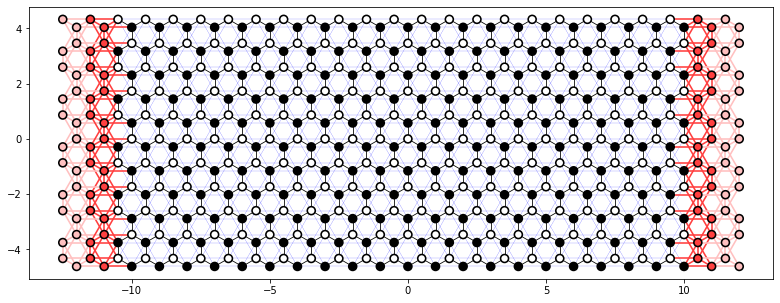

In [6]:
## Figure
fig, ax = plt.subplots(figsize=(20,5))
kwant.plot(system,
           site_color=family_colors,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=0.1, ax=ax)
ax.set_aspect('equal')
plt.show()

## Randomly placing the adatoms

We want to randomly place $N$ Hydrogen-atoms on top of Graphene sites. As a criteria, we want to avoid sites located at:
  
  * the boundaries of the scattering region
  * close to other adatoms

Since our system presents hoppings between next-nearest-neighbors, the sites allowed to host H-adatoms has to be at least one primitive vector away from the boundaries of the system. Now our task can be split into the following steps:

  1. to collect the sites of the system
  2. exclude those that are too close of the boundaries
  3. randomly choose one site (let's focus only on sites that belong to the A-sublattice)
  4. remove from the set of allowed sites those considered too close to the added adatom
  5. repeat the steps 3 and 4 until the desired density of adatoms or running out of legal sites

By inspection, one can see that the limits are different for each of the sublattices. 
For the sublattice **A** we have the following *tags*: 

In [7]:
first_component_tags_sublattice_A = np.unique([site.tag[0] for site in system.sites() if site.family==A])
second_component_tags_sublattice_A = np.unique([site.tag[1] for site in system.sites() if site.family==A])

print("First component of the tags for sublattice A sites : \n",
      first_component_tags_sublattice_A)
print("Second component of the tags for sublattice A sites : \n",
      second_component_tags_sublattice_A)

First component of the tags for sublattice A sites : 
 [-13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4
   5   6   7   8   9  10  11  12]
Second component of the tags for sublattice A sites : 
 [-5 -4 -3 -2 -1  0  1  2  3  4  5]


While the tags for the sublattice **B** are composed by the values: 

In [8]:
first_component_tags_sublattice_B = np.unique([site.tag[0] for site in system.sites() if site.family==B])
second_component_tags_sublattice_B = np.unique([site.tag[1] for site in system.sites() if site.family==B])
print("First component of the tag for sublattice B sites : \n",
      first_component_tags_sublattice_B)
print("Second component of the tag for sublattice B sites : \n",
      second_component_tags_sublattice_B)

First component of the tag for sublattice B sites : 
 [-12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5
   6   7   8   9  10  11  12  13]
Second component of the tag for sublattice B sites : 
 [-6 -5 -4 -3 -2 -1  0  1  2  3  4]


Excluding the sites at the boundaries and making the pairs of values:

In [9]:
x_component_sub_A = np.unique([site.pos[0] for site in system.sites() if site.family == A])
y_component_sub_A = np.unique([site.pos[1] for site in system.sites() if site.family == A])

print('x_A : \n', x_component_sub_A, '\n')
print('y_A : \n', y_component_sub_A, '\n')

x_A : 
 [-10.5 -10.   -9.5  -9.   -8.5  -8.   -7.5  -7.   -6.5  -6.   -5.5  -5.
  -4.5  -4.   -3.5  -3.   -2.5  -2.   -1.5  -1.   -0.5   0.    0.5   1.
   1.5   2.    2.5   3.    3.5   4.    4.5   5.    5.5   6.    6.5   7.
   7.5   8.    8.5   9.    9.5  10. ] 

y_A : 
 [-4.33012702 -3.46410162 -2.59807621 -1.73205081 -0.8660254   0.
  0.8660254   1.73205081  2.59807621  3.46410162  4.33012702] 



In [10]:
class Permition_Rectangular:
    def __init__(self, width, length, delta=1, centered=True):
        self.length = length
        self.width = width
        self.delta = delta
        
        if centered:
            self.x_inf = -(length/2 - delta)
            self.x_sup = -self.x_inf
            self.y_inf = -(width/2 - delta)
            self.y_sup = -self.y_inf
        else:
            self.x_inf = delta
            self.x_sup = length - delta
            self.y_inf = delta
            self.y_sup = width - delta
            
    def is_allowed(self, site):
        x, y = site.pos
        return self.x_inf <= x < self.x_sup and self.y_inf < y < self.y_sup

In [11]:
test = Permition_Rectangular(system_width, system_length)
allowed_sites = [site for site in system.sites() if test.is_allowed(site)] 

In [12]:
def color_allowed(site):
    if site in allowed_sites:
        color = 'C1'
    elif site.family == A:
        color = 'w'
    else:
        color = 'k'
    return color

def contour_allowed(site):
    if site in allowed_sites:
        lw = 0
    else:
        lw = 0.1
    return lw

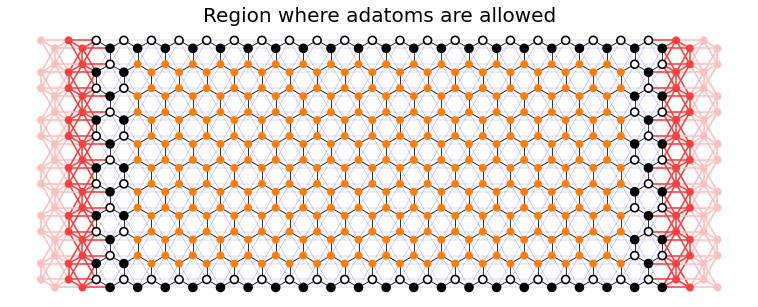

In [13]:
## Figure
fig, ax = plt.subplots(figsize=(20,5))
kwant.plot(system,
           site_color=color_allowed,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=contour_allowed,
           ax=ax)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Region where adatoms are allowed', fontsize=20)
plt.show()

In [14]:
# dir(A_allowed_sites)
# A_allowed_sites.remove()

In [15]:
def get_adatom_positions_balanced(total_number_of_adatoms, allowed_sites):
    A_adatoms_to_place = total_number_of_adatoms // 2
    B_adatoms_to_place = total_number_of_adatoms - A_adatoms_to_place

    list_of_A_adatoms = []
    list_of_B_adatoms = []

    while A_adatoms_to_place or B_adatoms_to_place:
#         print("A-adatoms do place = {:d}".format(A_adatoms_to_place))
#         print("B-adatoms do place = {:d}".format(B_adatoms_to_place))

        site_adatom = allowed_sites[np.random.choice(len(allowed_sites))]

        if site_adatom.family == A and A_adatoms_to_place:
            list_of_A_adatoms.append(site_adatom)
            allowed_sites = exclude_neighboring_sites(site_adatom, allowed_sites)
            A_adatoms_to_place -= 1
        elif site_adatom.family == B and B_adatoms_to_place:
            list_of_B_adatoms.append(site_adatom)
            allowed_sites = exclude_neighboring_sites(site_adatom, allowed_sites)
            B_adatoms_to_place -= 1
        
#         print("Number of allowed sites: ",len(allowed_sites))

        if not allowed_sites:
            break

    return list_of_A_adatoms, list_of_B_adatoms, allowed_sites
                
def get_adatom_positions_by_family(number_of_adatoms, allowed_sites, family=None):
    list_of_adatom_sites = []
    i = 1
    print('Number of adatoms wanted = ', number_of_adatoms)
    if family != None:
        allowed_sites = [site for site in allowed_sites if site.family == family]
    while i <= number_of_adatoms:
        site_adatom = allowed_sites[np.random.choice(len(allowed_sites))]
        allowed_sites = exclude_neighboring_sites(site_adatom, allowed_sites)
        list_of_adatom_sites.append(site_adatom)
#         print(i)
#         print('number of allowed sites = ', len(allowed_sites))
        if len(allowed_sites) < 1:
            print("Only {:d} adatoms were possible!".format(i))
            break
        i += 1
    print("{:d} adatoms were inserted".format(i-1))
    return list_of_adatom_sites, allowed_sites

def exclude_neighboring_sites(adatom_site, list_of_sites, radius=2):
    sites_to_exclude = neighboring_sites(adatom_site, list_of_sites, radius)
    for site in sites_to_exclude:
        list_of_sites.remove(site)
    return list_of_sites

def neighboring_sites(adatom_site, list_of_sites, radius):
    list_of_neighboring_sites = []
    xA, yA = adatom_site.pos
    for site in list_of_sites:
        x, y = site.pos
        if (x-xA)**2 + (y-yA)**2 <= radius**2:
            list_of_neighboring_sites.append(site)
    return list_of_neighboring_sites

## Positioning adatoms

In [16]:
total_of_sites = len(system.sites())
print('Total of Carbon atom sites = ', total_of_sites)

adatom_concentration = 2.0 # (% of C-atoms)
n_Hydrogen_sites = int(total_of_sites // (100/adatom_concentration))

# print(n_Hydrogen_sites)
print("To get a concentration of {:.2f} % of impurity we need to place {:d} adatoms".format(adatom_concentration, n_Hydrogen_sites))

Total of Carbon atom sites =  462
To get a concentration of 2.00 % of impurity we need to place 9 adatoms


In [17]:
number_of_adatoms = n_Hydrogen_sites
allowed_sites = [site for site in system.sites() if test.is_allowed(site)] 
list_of_adatom_sites, allowed_sites_1 = get_adatom_positions_by_family(number_of_adatoms, allowed_sites, family=B)

Number of adatoms wanted =  9
9 adatoms were inserted


In [18]:
class FormatMapSites:
    
    def __init__(self, allowed_sites, adatom_sites):
        self.allowed = allowed_sites
        self.adatoms = adatom_sites
        
    def color(self, site):
        if site in self.allowed:
            color = 'C1'
        elif site in self.adatoms and site.family == A:
            color = 'r'
        elif site in self.adatoms and site.family == B:
            color = 'magenta'
#         elif site.family == A:
#             color = 'w'
        else:
            color = 'w'
        return color

    def line_width(self, site):
        if site in self.allowed or site in self.adatoms:
            lw = 0
        else:
            lw = 0.05
        return lw

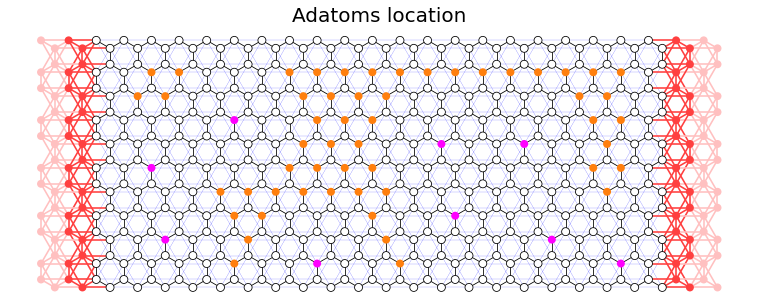

In [19]:
format_sites_1 = FormatMapSites(allowed_sites_1, list_of_adatom_sites)

## Figure
fig, ax = plt.subplots(figsize=(20,5))
kwant.plot(system,
           site_color=format_sites_1.color,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=format_sites_1.line_width,
           ax=ax)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Adatoms location', fontsize=20)
plt.show()

## Balanced distribution

In [20]:
number_of_adatoms = n_Hydrogen_sites
allowed_sites = [site for site in system.sites() if test.is_allowed(site)] 
list_of_A_adatom_sites, list_of_B_adatom_sites, allowed_sites_2 = get_adatom_positions_balanced(number_of_adatoms, allowed_sites)

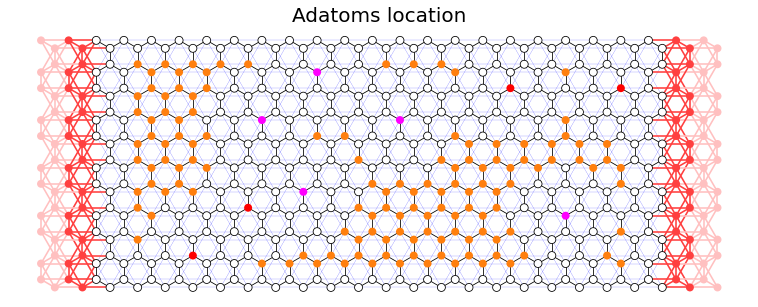

In [21]:
format_sites_2 = FormatMapSites(allowed_sites_2, list_of_A_adatom_sites + list_of_B_adatom_sites)


## Figure
fig, ax = plt.subplots(figsize=(20,5))
kwant.plot(system,
           site_color=format_sites_2.color,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=format_sites_2.line_width,
           ax=ax)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Adatoms location', fontsize=20)
plt.show()

Choosing N_A sites out of sublattice-A, and N_B sites out of sublattice-B.

In [22]:
## To get just one site out of 'A':
N_A_adatoms = len(list_of_A_adatom_sites) # number of allowed sites
N_B_adatoms = len(list_of_B_adatom_sites) # number of allowed sites
A_adatoms_tags = [site.tag for site in list_of_A_adatom_sites]
B_adatoms_tags = [site.tag for site in list_of_B_adatom_sites]

print("Number of adatoms on top of \n\tsublattice-A = {:d}".format(N_A_adatoms))
print("\tsublattice-B = {:d}".format(N_B_adatoms))

Number of adatoms on top of 
	sublattice-A = 4
	sublattice-B = 5


In [23]:
print(A_adatoms_tags)
print(np.array(A_adatoms_tags))

[array([7, 3]), array([-5, -4]), array([-4, -2]), array([3, 3])]
[[ 7  3]
 [-5 -4]
 [-4 -2]
 [ 3  3]]


In [24]:
np.random.seed()

### Defining the "pseudo-lattice" for H-atoms:

In [25]:
hydrogen = kwant.lattice.general([(1, 0), (sin_30, cos_30)], # primitive vectors
                                 [(0, 0), (0, 1 / np.sqrt(3))],        # coord. of basis atoms
                                 norbs = 2,                            # number of orbitals per site (spin)
                                 name='H'                              # name for identification
                                )
## Split in sublattices
HA, HB = hydrogen.sublattices

### Insert adatoms onto system

In [26]:
T = 1

for tagA in A_adatoms_tags:
    system[HA(*tagA)] = zeros_2x2   # on-site
    system[A(*tagA), HA(*tagA)] = T # hopping with C_H

for tagB in B_adatoms_tags:
    system[HB(*tagB)] = zeros_2x2   # on-site
    system[B(*tagB), HB(*tagB)] = T # hopping with C_H

In [27]:
def family_colors_H(site):
        if site.family == A:
            color = 'k'
        elif site.family == B:
            color = 'k'
        elif site.family == HA:
            color = 'cyan'
        elif site.family == HB:
            color = 'cyan'
        else:
            color = 'cyan'
        return color

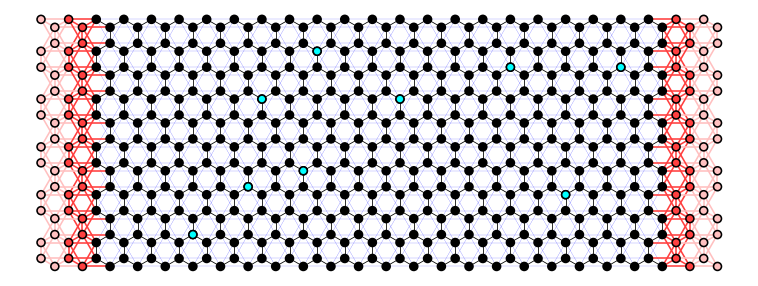

In [28]:
## Figure
fig, ax = plt.subplots(figsize=(20,5))
kwant.plot(system,
           site_color=family_colors_H,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=0.1, ax=ax)
ax.set_aspect('equal')
ax.axis('off')
plt.show()

$$
H_{ASO} = \frac{i}{3}\sum_{\langle\langle C_H, j \rangle\rangle} A^{\dagger}_{\sigma}c_{j,\sigma^{\prime}} \left[ \frac{\Lambda_I}{\sqrt{3}} \nu_{C_H, j} \hat{s}_z \right]_{\sigma, \sigma^{\prime}}
$$


$$
H_{BR} = \frac{2i}{3} \sum_{\langle C_H, j \rangle} A^{\dagger}_{\sigma}B_{j\sigma^{\prime}} \left[\Lambda_{BR} (\hat{s} \times \vec{d}_{C_H, j})_z\right]_{\sigma,\sigma^{\prime}}
$$

$$
H_{PIA} = \frac{2i}{3} \sum_{\langle\langle i,j \rangle\rangle} B^{\dagger}_{i\sigma}B_{j\sigma^{\prime}}[\Lambda_{PIA}(\hat{s}\times\vec{D}_{ij})_{z}]_{\sigma\sigma^{\prime}}
$$

[PRL 110, 246602 (2013)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.110.246602) 

## Getting the neighbors of the C_H's

To properly define the hoppings, we have to know where the adatoms are located and to keep track of its neighbors, the nearest (NN) and the next-nearest (NNN). It is important to pay attention to the situation in which the adatoms are placed on top of neighboring Carbon atoms. If the code are implemented in such a way that the different SOC contributions are added one-by-one, the hoppings between the neighbors $C_H$s might be updated wrongly, counting the same SOC contribution twice (or even more).

Let's do a brainstorm listing the steps required to define all hopping terms of the system:

1. Define the Graphene strip and the leads:
    - Carbon (C) atoms on-site energy
    - "A-B" hoppings (NN)
    - "A-A" and "B-B" hoppings (NNN) **ISO**
2. Place the H-adatoms:
    - Hydrogen atoms on-site ennergy
    - "H-C" hoppings
3. Get the neighbors of all the Carbon atom coupled to a H-atom ($C_H$):
    - Nearest-Neighbors (NN): different sublattices (for **BR** and **PIA**)
    - Next-Nearest-Neighbors (NNN): same sublattices (for **ASO**)
4. With the positions of $C_H$ and the their neighbors change the hoppings: **paying attention to duplicates**
    - List of $C_H$-sites
    - Two lists of neighbors for each of the $C_H$: NN's and NNN's.
    - **For each soc contribution** define a `list` or a `set` (updated pairs) on which we're going to put every pair of sites we have updated: The **PIA** pair of one site may form a NNN pair (**ASO**)  
    - Before changing the hopping verify if the pair of sites is already on the list.
    - Change the hoppings if the pair isn't in the list,...
    - ...then add the pair (site1,site2) and (site2,site1) on the list.  

In [29]:
# for s in system.sites():
#     if s.family==HA or s.family==HB:
#         print(s.family.name)
#         print('tag = ', s.tag)
#         print('type(tag) = ', type(s.tag))
#         print(type(s.pos), end='\n\n')

In [30]:
def get_CH(system, CH_sublattices, H_sublattices):
    """
    system := kwant.builder.Builder
    CH_sublattices := list of the graphene sublattices
    H_sublattices := list of H atoms sublattices
    """
    A, B = CH_sublattices
    HA, HB = H_sublattices
    
    list_CH = []
    
    for site in system.sites():
        if site.family == HA:
            list_CH.append(A(*site.tag))
        elif site.family == HB:
            list_CH.append(B(*site.tag))
    return list_CH

def get_neighbors(system, C_H_site, CH_sublattices):
    """
    Returns a list containing 2 other lists:
        - nn_list = list of nearest neighbors sites
        - nnn_list = list of next nearest neighbors sites
    """
    site_tag = C_H_site.tag
    site_sub = C_H_site.family
    nn_list = get_nn(system, site_tag, site_sub, CH_sublattices)
    nnn_list = get_nnn(system, site_tag, site_sub)
    return [nn_list, nnn_list]

def get_nn(system, tag, sub_s, list_sub_lat):
    """
    system := kwant.builder.Builder
    tag    := tuple (i,j) of the site's tag
    sub_s  := site's sublattice
    
    Notice that 
    """
    list_sub_lat.remove(sub_s) # remove the sublattice to which the site belongs
    sub_nn, = list_sub_lat     # extract the sublattice of the neighbors
    # print(sub_nn.name[-1])
    name_indx = int(sub_s.name[-1])
    delta = +1 if name_indx == 0 else -1
#     print(delta)
    i,j = tag
    nn_tag_list = [(i,j), (i+delta,j-delta), (i,j-delta)] 
    nn_sites = [
        sub_nn(*t) for t in nn_tag_list if sub_nn(*t) in system
    ]
#     for site in nn_sites:
#         print(site)
    return nn_sites
        
def get_nnn(system, tag, sub_s):
    """
    system := kwant.builder.Builder
    tag    := tuple (i,j) of the site's tag
    sub_s  := site's sublattice
    
    Notice that 
    """
    #sub_nnn = sub_s

    i,j = tag
    nnn_tag_list = [(  i,j+1), (i+1,  j),
                    (i+1,j-1), (  i,j-1),
                    (i-1,  j), (i-1,j+1)] 
    nnn_sites = [
        sub_s(*t) for t in nnn_tag_list if sub_s(*t) in system
    ]
#     for site in nnn_sites:
#         print(site)
    return nnn_sites

In [31]:
CH_sites = get_CH(system, [A,B], [HA,HB])

for site in CH_sites:
    print(site)

<Site [7 3] of Graphene0>
<Site [-5 -4] of Graphene0>
<Site [-4 -2] of Graphene0>
<Site [3 3] of Graphene0>
<Site [0 1] of Graphene1>
<Site [-5 1] of Graphene1>
<Site [8 -3] of Graphene1>
<Site [-2 -2] of Graphene1>
<Site [-4 3] of Graphene1>


In [32]:
all_neighbors = [get_neighbors(system, CH, [A,B]) for CH in CH_sites]

all_NN_neighbors = [a[0] for a in all_neighbors]
all_NNN_neighbors = [a[1] for a in all_neighbors]


## Including the SOC terms induced by the adatoms

#### Adatom induced spin-orbit coupling (ASO)

In [33]:
## FOR EACH ADATOM:
def include_ASO_sitewise(system, CH_site, NNN_site, hop_list, Lambda_I):
    """
    This function has two effects:
        1. Define a hopping between CH_site and NNN_site
        2. Returns an updated hop_list
    
    Naturaly, the first effect occurs only in the case the hopping 
    isn't on the list. Otherwise the hopping will not be included and
    the hop_list will not be altered.
    """
    # 1. Verify if the hopping is duplicated
    if (CH_site, NNN_site) not in hop_list: 

        # 2.1. Identify the hopping 1/2
        delta_tag = list(NNN_site.tag - CH_site.tag)
        if delta_tag in ([0,1], [1,-1], [-1,0]): sign = -1
        else: sign = +1
        
        # 2.2. Identify the hopping 2/2
        family_id  = 1 - 2 * int(CH_site.family.name[-1]) ## 1 (-1) if sublattice == A (B)
        
        # 3. Define the hopping
        H_asoc = sign * family_id * 1j/3 * Lambda_I/np.sqrt(3) * sigma_z # clockwise    
        system[CH_site, NNN_site] = H_asoc ## sytem[sublat_1(target), sublat_2(source)]
        
        # 4. Save pairs in hop_list
        hop_list.append((CH_site, NNN_site)) # (CH, NNN)
        hop_list.append((NNN_site, CH_site)) # (NNN, CH)
        
    return hop_list


def include_BR_sitewise(system, CH_site, NN_site, hop_list, Lambda_BR):
    """
    This function has two effects:
        1. Define a hopping between CH_site and NN_site
        2. Returns an updated hop_list
    
    The first effect occurs only in the case the hopping 
    isn't on the list. Otherwise the hopping will not be included and
    the hop_list will not be altered.
    """
    # 1. Verify if the hopping is duplicated
    if (CH_site, NN_site) not in hop_list:
        
        # 2. Identify the hopping 2/2:
        dx, dy = np.sqrt(3) * (CH_site.pos - NN_site.pos) 
        H_BR = (2j/3) * Lambda_BR * (dy * sigma_x - dx * sigma_y) ## (S X d_ij)_z 
        
        # 3. Define the hopping
        system[CH_site, NN_site] += H_BR
        
        # 4. Save pairs in hop_list
        hop_list.append((CH_site, NN_site)) # (CH, NNN)
        hop_list.append((NN_site, CH_site)) # (NNN, CH)
        
    return hop_list


def include_PIA_sitewise(system, site_target, site_source, hop_list, Lambda_PIA, iso):
    """
    This function has two effects:
        1. Define a hopping between CH_site and NN_site
        2. Returns an updated hop_list
    
    The first effect occurs only in the case the hopping 
    isn't on the list. Otherwise the hopping will not be included and
    the hop_list will not be altered.
    """
    # 1. Verify if the hopping is duplicated
    if (site_target, site_source) not in hop_list:
        
        # 2. Identify the hopping:
        Dx, Dy = site_target.pos - site_source.pos
        
        # 3. Define the hopping
        H_PIA =  2j/3 * Lambda_PIA * (Dy * sigma_x - Dx * sigma_y) ## (S x D_ij)_z
        if iso:
            system[site_target, site_source] += H_PIA
        else:
            system[site_target, site_source] = H_PIA
        
        # 4. Save pairs in hop_list
        hop_list.append((site_target, site_source)) # (site1, site2)
        hop_list.append((site_source, site_target)) # (site2, site1)
        
    return hop_list

## FOR ALL ADATOMS:
def include_all_ASO(system, all_CH_sites, all_NNN_neighbors, Lambda_I=1):
    hop_list_ASO = []
    for CH_site, NNN_sites in zip(all_CH_sites, all_NNN_neighbors):
        for NNN_site in NNN_sites:
            include_ASO_sitewise(system, CH_site, NNN_site, hop_list_ASO, Lambda_I)


def include_all_BR(system, all_CH_sites, all_NN_neighbors, Lambda_BR=1):
    hop_list_BR = []
    for CH_site, NN_sites in zip(all_CH_sites, all_NN_neighbors):
        print(len(NN_sites))
        for NN_site in NN_sites:
            print(NN_site)
            include_BR_sitewise(system, CH_site, NN_site, hop_list_BR, Lambda_BR)
            

def include_all_PIA(system, all_NN_neighbors, Lambda_PIA=1, iso=True):
    hop_list_PIA = []
    for NN_sites in all_NN_neighbors:
        targets = [NN_sites[(i+1)%3] for i in range(3)]
        for site1, site2 in zip(targets, NN_sites):
            print(site1, '<--', site2)
            include_PIA_sitewise(system, site1, site2, hop_list_PIA, Lambda_PIA, iso)

In [34]:
## Calculate and include the Adatom induced spin-orbit coupling
include_all_ASO(system, CH_sites, all_NNN_neighbors)

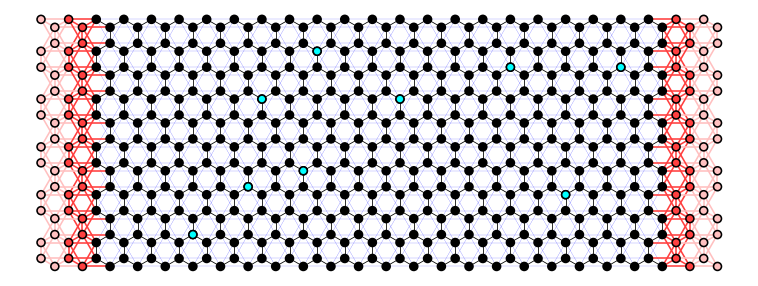

In [35]:
## Figure
fig, ax = plt.subplots(figsize=(20,5))
kwant.plot(system,
           site_color=family_colors_H,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=0.1, ax=ax)
ax.set_aspect('equal')
ax.axis('off')
plt.show()

#### Bychkov-Rashba spin-orbit coupling (BR)

In [36]:
## Calculate and include into the system the Bychkov-Rashba spin-orbit coupling (BR)
include_all_BR(system, CH_sites, all_NN_neighbors)

3
<Site [7 3] of Graphene1>
<Site [8 2] of Graphene1>
<Site [7 2] of Graphene1>
3
<Site [-5 -4] of Graphene1>
<Site [-4 -5] of Graphene1>
<Site [-5 -5] of Graphene1>
3
<Site [-4 -2] of Graphene1>
<Site [-3 -3] of Graphene1>
<Site [-4 -3] of Graphene1>
3
<Site [3 3] of Graphene1>
<Site [4 2] of Graphene1>
<Site [3 2] of Graphene1>
3
<Site [0 1] of Graphene0>
<Site [-1 2] of Graphene0>
<Site [0 2] of Graphene0>
3
<Site [-5 1] of Graphene0>
<Site [-6 2] of Graphene0>
<Site [-5 2] of Graphene0>
3
<Site [8 -3] of Graphene0>
<Site [7 -2] of Graphene0>
<Site [8 -2] of Graphene0>
3
<Site [-2 -2] of Graphene0>
<Site [-3 -1] of Graphene0>
<Site [-2 -1] of Graphene0>
3
<Site [-4 3] of Graphene0>
<Site [-5 4] of Graphene0>
<Site [-4 4] of Graphene0>


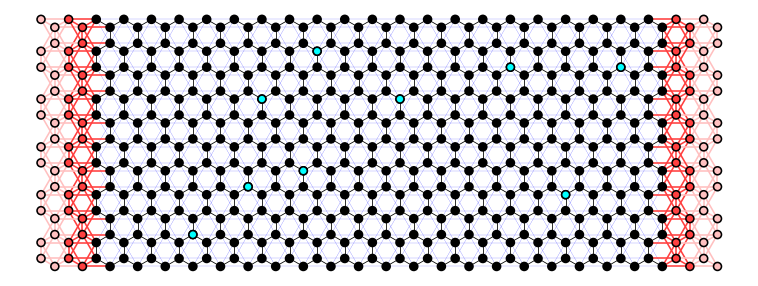

In [37]:
## Figure
fig, ax = plt.subplots(figsize=(20,5))
kwant.plot(system,
           site_color=family_colors_H,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=0.1, ax=ax)
ax.set_aspect('equal')
ax.axis('off')
plt.show()

### Pseudo-spin inversion asymmetry SOC (PIA)

In [38]:
## Calculate and include into the system the Pseudo-spin inversion asymmetry spin-orbit coupling (PIA)
include_all_PIA(system, all_NN_neighbors)

<Site [8 2] of Graphene1> <-- <Site [7 3] of Graphene1>
<Site [7 2] of Graphene1> <-- <Site [8 2] of Graphene1>
<Site [7 3] of Graphene1> <-- <Site [7 2] of Graphene1>
<Site [-4 -5] of Graphene1> <-- <Site [-5 -4] of Graphene1>
<Site [-5 -5] of Graphene1> <-- <Site [-4 -5] of Graphene1>
<Site [-5 -4] of Graphene1> <-- <Site [-5 -5] of Graphene1>
<Site [-3 -3] of Graphene1> <-- <Site [-4 -2] of Graphene1>
<Site [-4 -3] of Graphene1> <-- <Site [-3 -3] of Graphene1>
<Site [-4 -2] of Graphene1> <-- <Site [-4 -3] of Graphene1>
<Site [4 2] of Graphene1> <-- <Site [3 3] of Graphene1>
<Site [3 2] of Graphene1> <-- <Site [4 2] of Graphene1>
<Site [3 3] of Graphene1> <-- <Site [3 2] of Graphene1>
<Site [-1 2] of Graphene0> <-- <Site [0 1] of Graphene0>
<Site [0 2] of Graphene0> <-- <Site [-1 2] of Graphene0>
<Site [0 1] of Graphene0> <-- <Site [0 2] of Graphene0>
<Site [-6 2] of Graphene0> <-- <Site [-5 1] of Graphene0>
<Site [-5 2] of Graphene0> <-- <Site [-6 2] of Graphene0>
<Site [-5 1] of Gr

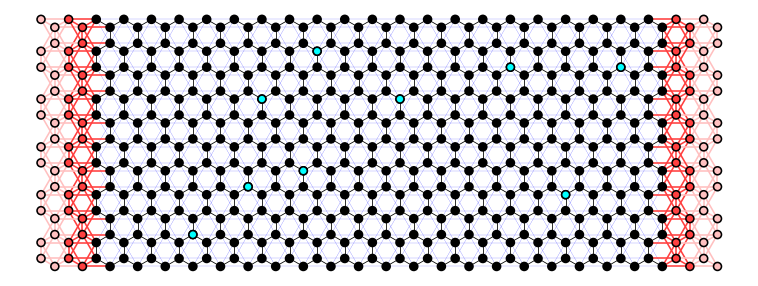

In [39]:
## Figure
fig, ax = plt.subplots(figsize=(20,5))
kwant.plot(system,
           site_color=family_colors_H,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=0.1, ax=ax)
ax.set_aspect('equal')
ax.axis('off')
plt.show()

## Checking the hoppings

Since we have fixed the seed for both of the sampling processes (one for HA positions and other for HB positions), we can treat the specific hoppings and check if their values are correct. Let's focus on the hoppings surrounding or point towards the site at the position $x=0$ and $y=0$.

$$
[A_{00}, B_{0-1}] = t \begin{pmatrix} 1 & 0\\0 & 1 \end{pmatrix} + \Lambda_{BR} \left[ \frac{1}{3}\begin{pmatrix} 0 & i\\i & 0 \end{pmatrix} - \sqrt{3}\begin{pmatrix} 0 & 1\\-1 & 0 \end{pmatrix} \right]
$$

In [40]:
print(system[A(0,0), B(0,-1)]) ## Has to be identical to the matrix above

[[1 0]
 [0 1]]


In [41]:
print(system[B(0,-1), A(0,0)]) ## Has to be the adjunt of the previous matrix

[[1 0]
 [0 1]]


## Preparation for PBC systems

In [42]:
class Permition_PBC:
    def __init__(self, max_a1_component, max_a2_component, delta=1):
        self.a1_inf = delta 
        self.a1_sup = max_a1_component - delta
        self.a2_inf = delta
        self.a2_sup = max_a2_component - delta
        
    def is_allowed(self, site):
        a1, a2 = site.tag
        return self.a1_inf <= a1 < self.a1_sup and self.a2_inf <= a2 < self.a2_sup

In [43]:
def make_PBC_system(N1=10, N2=20, pot=0, t=2.6):
    #### Define the scattering region. ####
    syst = kwant.Builder()
    for a1 in range(N1):
        for a2 in range(N2):
            syst[A(a1, a2)] = -pot
            syst[B(a1, a2)] = -pot

    # specify the hoppings of the graphene lattice in the
    # format expected by builder.HoppingKind
    hoppings = (((0, 0), A, B), ((0, 1), A, B), ((-1, 1), A, B))
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -t

    ## Horizontal hoppings PBC
    for j in range(1, N2):
        syst[A(N1-1, j), B(0,j-1)] = -t

    ## Vertical hopping PBC
    for i in range(N1):
        syst[B(i, N2-1), A(i, 0)] = -t
        syst[B((i+1) % N1, N2-1), A(i, 0)] = -t

    return syst

In [44]:
a1_max_comp = 10
a2_max_comp = 10

pbc_system = make_PBC_system(N1=a1_max_comp, N2=a2_max_comp)

In [45]:
test_pbc = Permition_PBC(a1_max_comp, a2_max_comp, delta=2)

allowed_sites_pbc = [site for site in pbc_system.sites() if test_pbc.is_allowed(site)] 

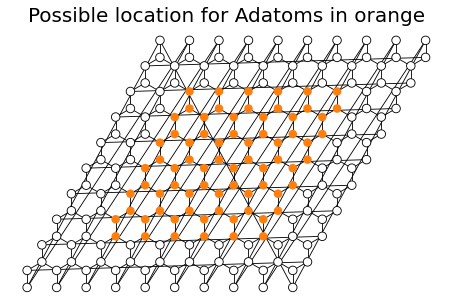

In [46]:
format_sites_3 = FormatMapSites(allowed_sites_pbc, [])

## Figure
fig, ax = plt.subplots(figsize=(20,5))
kwant.plot(pbc_system,
           site_color=format_sites_3.color,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=format_sites_3.line_width,
           ax=ax)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Possible location for Adatoms in orange', fontsize=20)
plt.show()

In [47]:
number_of_adatoms_pbc = 2
list_of_A_adatom_sites_pbc, list_of_B_adatom_sites_pbc, allowed_sites_pbc_2 = get_adatom_positions_balanced(
                                                                    number_of_adatoms_pbc,
                                                                    allowed_sites_pbc)

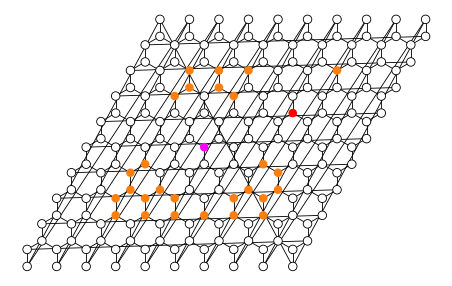

In [48]:
format_sites_pbc_2 = FormatMapSites(allowed_sites_pbc_2, list_of_A_adatom_sites_pbc + list_of_B_adatom_sites_pbc)

## Figure
fig, ax = plt.subplots(figsize=(20,5))
kwant.plot(pbc_system,
           site_color=format_sites_pbc_2.color,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=format_sites_pbc_2.line_width,
           ax=ax)
ax.set_aspect('equal')
ax.axis('off')
# ax.set_title('Possible location for Adatoms in orange', fontsize=20)
plt.show()

In [49]:
A_adatoms_tags_pbc = [site.tag for site in list_of_A_adatom_sites_pbc]
B_adatoms_tags_pbc = [site.tag for site in list_of_B_adatom_sites_pbc]

In [50]:
T = 7.5
epsilon = 0.16

for tagA in A_adatoms_tags_pbc:
    pbc_system[HA(*tagA)] = sigma_0 * epsilon   # on-site
    pbc_system[A(*tagA), HA(*tagA)] = T # hopping with C_H

for tagB in B_adatoms_tags_pbc:
    pbc_system[HB(*tagB)] = sigma_0 * epsilon   # on-site
    pbc_system[B(*tagB), HB(*tagB)] = T # hopping with C_H

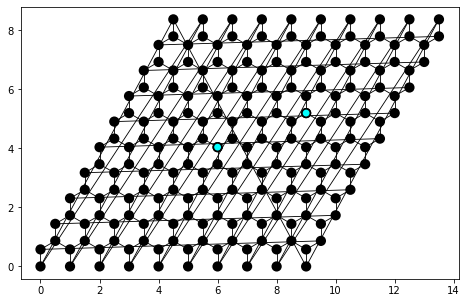

In [51]:
fig, ax = plt.subplots(figsize=(20,5))
kwant.plot(pbc_system,
           site_color=family_colors_H,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=0.1, ax=ax)
ax.set_aspect('equal')
# ax.axis('off')
plt.show()

In [52]:
get_nn(pbc_system, [7,5], A, [A,B])

[Site(kwant.lattice.Monatomic([[1.0, 0.0], [0.5, 0.8660254037844386]], [0.0, 0.5773502691896258], 'Graphene1', 2), array([7, 5])),
 Site(kwant.lattice.Monatomic([[1.0, 0.0], [0.5, 0.8660254037844386]], [0.0, 0.5773502691896258], 'Graphene1', 2), array([8, 4])),
 Site(kwant.lattice.Monatomic([[1.0, 0.0], [0.5, 0.8660254037844386]], [0.0, 0.5773502691896258], 'Graphene1', 2), array([7, 4]))]

In [53]:
CH_sites_pbc = list_of_A_adatom_sites_pbc + list_of_B_adatom_sites_pbc

In [54]:
all_neighbors_pbc = [get_neighbors(pbc_system, CH, [A,B]) for CH in CH_sites_pbc]
all_NN_neighbors_pbc = [a[0] for a in all_neighbors_pbc]
all_NNN_neighbors_pbc = [a[1] for a in all_neighbors_pbc]

In [55]:
for i in range(len(CH_sites_pbc)):
    print('The {:d}-th adatom host has {:d} 1st neighbors.'.format(i, len(all_neighbors_pbc[0][0])))
    print('The {:d}-th adatom host has {:d} 2nd neighbors.\n'.format(i, len(all_neighbors_pbc[0][1])))

The 0-th adatom host has 3 1st neighbors.
The 0-th adatom host has 6 2nd neighbors.

The 1-th adatom host has 3 1st neighbors.
The 1-th adatom host has 6 2nd neighbors.



In [56]:
## Calculate and include the Adatom induced spin-orbit coupling
include_all_ASO(pbc_system, CH_sites_pbc, all_NNN_neighbors_pbc)

In [57]:
## Calculate and include into the system the Bychkov-Rashba spin-orbit coupling (BR)
include_all_BR(pbc_system, CH_sites_pbc, all_NN_neighbors_pbc)

3
<Site [6 6] of Graphene1>
<Site [7 5] of Graphene1>
<Site [6 5] of Graphene1>
3
<Site [4 4] of Graphene0>
<Site [3 5] of Graphene0>
<Site [4 5] of Graphene0>


In [58]:
## Calculate and include into the system the Pseudo-spin inversion asymmetry spin-orbit coupling (PIA)
include_all_PIA(pbc_system, all_NN_neighbors_pbc, iso=False)

# hop_list_PIA = []
# for NN_sites in all_NN_neighbors_pbc:
#     print('site_0 = ', NN_sites[0])
#     print('site_1 = ', NN_sites[1])
#     print('site_2 = ', NN_sites[2])
# #     targets = [NN_sites[(i+1)%3] for i in range(3)]
# #     print(targets)
# #     for site1, site2 in zip(targets, NN_sites):
# #         print(site1, '<--', site2)
# #         include_PIA_sitewise(system, site1, site2, hop_list_PIA, Lambda_PIA)

<Site [7 5] of Graphene1> <-- <Site [6 6] of Graphene1>
<Site [6 5] of Graphene1> <-- <Site [7 5] of Graphene1>
<Site [6 6] of Graphene1> <-- <Site [6 5] of Graphene1>
<Site [3 5] of Graphene0> <-- <Site [4 4] of Graphene0>
<Site [4 5] of Graphene0> <-- <Site [3 5] of Graphene0>
<Site [4 4] of Graphene0> <-- <Site [4 5] of Graphene0>


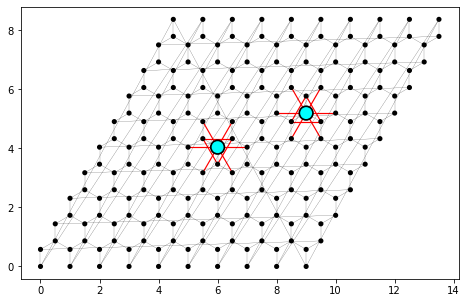

In [59]:
def hopping_colors(site1, site2):
#     if (site1.family==A and site1.family==site2.family) and (site1.tag == np.array([0,0]) or site2.tag == np.array([0,0])): # and site1.tag == np.array([0,0]) and site1.family==A:
#         color = 'red'
    if site1.family == site2.family:
        color='red'
    else:
        color='black'
    return color

def hopping_lw(site1, site2):
    return 0.07 if site1.family == site2.family else 0.01

def site_size_function(site):
    if site.family == HA or site.family==HB:
        size = 0.4
    else:
        size = 0.1
    return size

fig, ax = plt.subplots(figsize=(20,5))
kwant.plot(pbc_system,
           site_color=family_colors_H,
           site_size=site_size_function,
           hop_color=hopping_colors,
           hop_lw=hopping_lw,
           site_lw=0.1, ax=ax)
ax.set_aspect('equal')
# ax.axis('off')
plt.show()

In [60]:
pbc_system[A(0,0), B(0,0)]

-2.6

In [61]:
len(pbc_system.sites())

202

## Considerations:

The model wasn't thought to be used in a system with high concentration of H-atoms, the exercise here was good to see the difficulties to define such a system. The concentration aimed is something lower than 10% with very sparsed location for the H-atom: 1 H-atom for 10 C-atoms without overlap. From here, we have to address the following scenarios:

* Graphene with ISO
* Graphene + ISO + Adatom at the Center
* Graphene + ISO + Adatom at the Center + Magnetic Field
* Graphene + ISO + Adatom at the Center + Magnetic Field + Magnetic moment

## Tests 

In [62]:
matrix = np.random.random([3,3])
print(matrix)

null_matrix = 0
print(matrix + null_matrix)

[[0.48517477 0.24216319 0.65397671]
 [0.16663843 0.32194433 0.01611685]
 [0.91448995 0.53785952 0.52888193]]
[[0.48517477 0.24216319 0.65397671]
 [0.16663843 0.32194433 0.01611685]
 [0.91448995 0.53785952 0.52888193]]


In [63]:
def Vfunction_test(site, t):
    x, y = site.pos
    return 4*t

def hopping_test(site1, site2, t):
    return -t

In [64]:
shape_test = Rectangle(3, 3)
system_test = kwant.Builder()
sqr_lattice = kwant.lattice.square(a=1)

In [65]:
system_test[sqr_lattice.shape(shape_test, (0, 0))] = Vfunction_test
system_test[sqr_lattice.neighbors()] = hopping_test

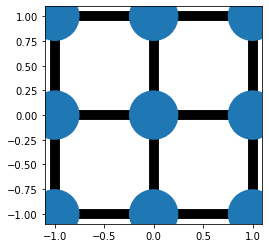

In [66]:
kwant.plot(system_test);

In [67]:
system_test[sqr_lattice(0,0), sqr_lattice(1,0)].substituted(t='t_special')

AttributeError: 'HermConjOfFunc' object has no attribute 'substituted'